In [106]:
#泰坦尼克号存活人数预测
import pandas as pd
import numpy as np
from woe import WoE # 从本地导入


#1.数据获取与导入阶段
data=pd.read_csv('train.csv')

#将Cabin的值进行分类处理
data.loc[ (data.Cabin.notnull()), 'Cabin' ] = 1
data.loc[ (data.Cabin.isnull()), 'Cabin' ] = 0
data['Cabin']=data['Cabin'].astype(int)


#将Sex和Embarked做转换

data['Embarked']=data.Embarked.fillna(value='S')

sex_dict={'female':'1','male':'0'}
data['Sex']=data.Sex.map(sex_dict).astype(int)

embarked_dict={'S':'1','C':'2','Q':'3'}
data['Embarked']=data.Embarked.map(embarked_dict).astype(int)


#目标变量
y = 'Survived'

# 连续变量
var_c = ['Age','Fare']

# 分类变量
var_d = ['Sex','Cabin','Embarked','Pclass','Parch','SibSp']

# **WoE类参数说明**:
# + **qnt_num**:int,等频分箱个数,默认16
# + **min_block_size**:int,最小观测数目，默认16
# + **spec_values**:dict,若为分类自变量，指派替换值
# + **v_type**:str,自变量类型,分类:‘d’,连续变量:‘c’，默认'c'
# + **bins**:list,预定义的连续变量分箱区间
# + **t_type**:str,目标变量类型,二分类:‘b’,连续变量:‘c’，默认'b'

# **WoE类重要方法**:
# 
# + **plot**:绘制WOE图
# + **transform**:转换数据为WOE数据
# + **fit_transform**:转换数据为WOE数据
# + **optimize**:连续变量使用最优分箱

# **WoE类重要属性**:
# + **bins**:分箱结果汇总
# + **iv**:变量的信息价值

# ## 根据IV值筛选变量 - 分类变量



X = data[var_c + var_d].copy()

Y = data[y].copy()

iv_d = {}
for i in var_d:
    iv_d[i] = WoE(v_type='d').fit(X[i].copy(), Y.copy()).iv

pd.Series(iv_d).sort_values(ascending = False)


iv_c = {}
for i in var_c:
    iv_c[i] = WoE(v_type='c',t_type='b',qnt_num=3).fit(X[i],Y).iv 

sort_iv_c = pd.Series(iv_c).sort_values(ascending=False)
sort_iv_c


X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Age         714 non-null float64
Fare        891 non-null float64
Sex         891 non-null int32
Cabin       891 non-null int32
Embarked    891 non-null int32
Pclass      891 non-null int64
Parch       891 non-null int64
SibSp       891 non-null int64
dtypes: float64(2), int32(3), int64(3)
memory usage: 45.3 KB


In [107]:
#2.针对每个变量的探索阶段

# 利用众数减去中位数的差值除以四分位距来查找是否有可能存在异常值
abs((X[var_c].mode().iloc[0,] - X[var_c].median()) /
    (X[var_c].quantile(0.75) - X[var_c].quantile(0.25)))


# ## 对分类变量的统计探索
#查看是否分类过多
# In[15]:
X['Parch'].value_counts()
X['SibSp'].value_counts()

len(X['SibSp'].value_counts())
X['Embarked'].value_counts()

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Age         714 non-null float64
Fare        891 non-null float64
Sex         891 non-null int32
Cabin       891 non-null int32
Embarked    891 non-null int32
Pclass      891 non-null int64
Parch       891 non-null int64
SibSp       891 non-null int64
dtypes: float64(2), int32(3), int64(3)
memory usage: 45.3 KB


In [168]:
#3.针对有问题的变量进行修改

# 查看缺失比例

1 - (X.describe().T["count"]) / len(X)

#Age 缺失值为19.8%，使用中位数来填补
#X['Age']=X.Age.fillna(X.Age.median())
#X=X.drop(['Age','Fare'],axis=1)
X=X.drop(['Parch'],axis=1)
X.head()

,Sex,Cabin,Embarked,Pclass,SibSp
0,0,0,1,3,1
1,1,1,2,1,1
2,1,0,1,3,0
3,1,1,1,1,1
4,0,0,1,3,0


In [169]:
import sklearn.model_selection as model_selection
ml_data = model_selection.train_test_split(X, Y, test_size=0.3, random_state=0)
train_data, test_data, train_target, test_target = ml_data

In [203]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

train_data = min_max_scaler.fit_transform(train_data)
test_data = min_max_scaler.fit_transform(test_data)
train_data

array([[0.   , 1.   , 0.   , 0.   , 0.   ],
       [1.   , 1.   , 0.5  , 0.   , 0.125],
       [0.   , 0.   , 0.   , 1.   , 0.625],
       ...,
       [0.   , 0.   , 1.   , 1.   , 0.   ],
       [1.   , 0.   , 0.   , 1.   , 0.125],
       [0.   , 0.   , 0.   , 0.5  , 0.125]])

In [171]:
import sklearn.linear_model as linear_model
logistic_model = linear_model.LogisticRegression(class_weight = None,
                                                 dual = False,
                                                 fit_intercept = True,
                                                 intercept_scaling = 1,
                                                 penalty = 'l1',
                                                 random_state = None,
                                                 tol = 0.001)

In [172]:
from sklearn.model_selection import ParameterGrid, GridSearchCV

C = np.logspace(-3,0,20,base=10)

param_grid = {'C': C}

clf_cv = GridSearchCV(estimator=logistic_model, 
                      param_grid=param_grid, 
                      cv=5, 
                      scoring='roc_auc')

clf_cv.fit(train_data, train_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.001  , 0.00144, 0.00207, 0.00298, 0.00428, 0.00616, 0.00886,
       0.01274, 0.01833, 0.02637, 0.03793, 0.05456, 0.07848, 0.11288,
       0.16238, 0.23357, 0.33598, 0.48329, 0.69519, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [193]:
logistic_model = linear_model.LogisticRegression(C=clf_cv.best_params_["C"],
                                                 class_weight=None,
                                                 dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 penalty='l1',
                                                 random_state=None,
                                                 tol=0.001)
logistic_model.fit(train_data, train_target)

LogisticRegression(C=0.23357214690901212, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.001, verbose=0, warm_start=False)

In [194]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model=X.join(train_target)
'''
['Sex','Cabin','Embarked','Pclass','Parch','SibSp']
'''


formula = "Survived ~ " + "+".join(X)
lg_m = smf.glm(formula=formula, data=model, 
             family=sm.families.Binomial(sm.families.links.logit)).fit()
lg_m.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.1809,0.500,-0.362,0.718,-1.161,0.800
Sex,2.7082,0.230,11.759,0.000,2.257,3.160
Cabin,0.4555,0.342,1.331,0.183,-0.215,1.126
Embarked,0.2633,0.163,1.617,0.106,-0.056,0.582
Pclass,-0.7266,0.182,-3.995,0.000,-1.083,-0.370
SibSp,-0.3107,0.120,-2.594,0.009,-0.545,-0.076


AUC = 0.8467


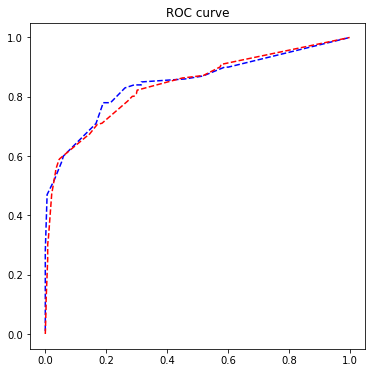

In [195]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

test_est = logistic_model.predict(test_data)
train_est = logistic_model.predict(train_data)

test_est_p = logistic_model.predict_proba(test_data)[:,1]
train_est_p = logistic_model.predict_proba(train_data)[:,1]

fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test, 'b--')
plt.plot(fpr_train, tpr_train, 'r--')
plt.title('ROC curve')
print('AUC = %6.4f' %metrics.auc(fpr_test, tpr_test))


In [196]:
#处理test.csv文件（和train一样需要做预处理）


data_=pd.read_csv('test.csv')
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 27.8+ KB


In [197]:
#将Cabin的值进行分类处理
data_.loc[ (data_.Cabin.notnull()), 'Cabin' ] = 1
data_.loc[ (data_.Cabin.isnull()), 'Cabin' ] = 0
data_['Cabin']=data_['Cabin'].astype(int)


'''
Age	Fare	Sex	Cabin	Embarked	Pclass	Parch	SibSp
'''


#将Sex和Embarked做转换

#data['Embarked']=data.Embarked.fillna(value='S')

sex_dict={'female':'1','male':'0'}
data_['Sex']=data_.Sex.map(sex_dict).astype(int)

embarked_dict={'S':'1','C':'2','Q':'3'}
data_['Embarked']=data_.Embarked.map(embarked_dict).astype(int)

data_.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int32
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          418 non-null int32
Embarked       418 non-null int32
dtypes: float64(2), int32(3), int64(4), object(2)
memory usage: 27.8+ KB


In [198]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int32
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          418 non-null int32
Embarked       418 non-null int32
dtypes: float64(2), int32(3), int64(4), object(2)
memory usage: 27.8+ KB


In [199]:
var=['Sex','Cabin','Embarked','Pclass','Parch','SibSp','Age','Fare']

XX=data_[var].copy()
XX.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Sex         418 non-null int32
Cabin       418 non-null int32
Embarked    418 non-null int32
Pclass      418 non-null int64
Parch       418 non-null int64
SibSp       418 non-null int64
Age         332 non-null float64
Fare        417 non-null float64
dtypes: float64(2), int32(3), int64(3)
memory usage: 21.3 KB


In [200]:
# 查看缺失比例

1 - (XX.describe().T["count"]) / len(XX)


#Age 缺失值为19.8%，Fare,使用中位数来填补
XX['Age']=XX.Age.fillna(XX.Age.median())
XX['Fare']=XX.Fare.fillna(XX.Fare.median())

XX=XX.drop(['Age','Fare','SibSp'],axis=1)
XX.head()

,Sex,Cabin,Embarked,Pclass,Parch
0,0,0,3,3,0
1,1,0,1,3,0
2,0,0,3,2,0
3,0,0,1,3,0
4,1,0,1,3,1


In [201]:
test= min_max_scaler.fit_transform(XX)
predict=logistic_model.predict(test)
predict

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [202]:
result = pd.DataFrame({'PassengerId':data_['PassengerId'].as_matrix(), 'Survived':predict})
result.to_csv("logistic_regression_predictions.csv", index=False)

c:\python36\install\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [206]:
from sklearn import cross_validation

 #简单看看打分情况
print(cross_validation.cross_val_score(logistic_model, X, Y, cv=10))

[0.82222222 0.76666667 0.78651685 0.83146067 0.82022472 0.7752809
 0.78651685 0.76404494 0.82022472 0.78409091]


In [210]:
from sklearn.ensemble import BaggingRegressor

bagging_clf = BaggingRegressor(logistic_model, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(train_data, train_target)

predict = bagging_clf.predict(test)
result = pd.DataFrame({'PassengerId':data_['PassengerId'].as_matrix(), 'Survived':predict.astype(np.int32)})
#result.info()
result.to_csv("logistic_regression_bagging_predictions.csv", index=False)

c:\python36\install\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
